In [1]:
@info pwd()
import Pkg.activate as pactivate
pactivate("../../")
JULIA_DEBUG=Main
using Plots, Statistics, DelimitedFiles
pyplot()

[ Info: /Users/jun/codes/SPM.jl/test/notebooks
  Activating project at `~/codes/SPM.jl`


Plots.PyPlotBackend()

In [2]:
include("../../src/SPM.jl")

Main.SPM

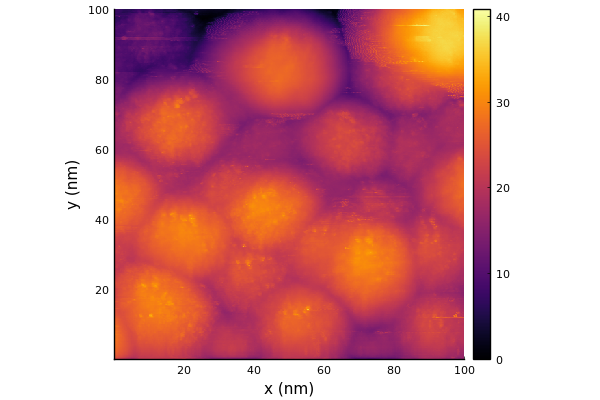

In [3]:
image = SPM.HDR.loadHDR("../data/B3446.hdr")
SPM.SPMCore.showHeatmap(image; legend=true)

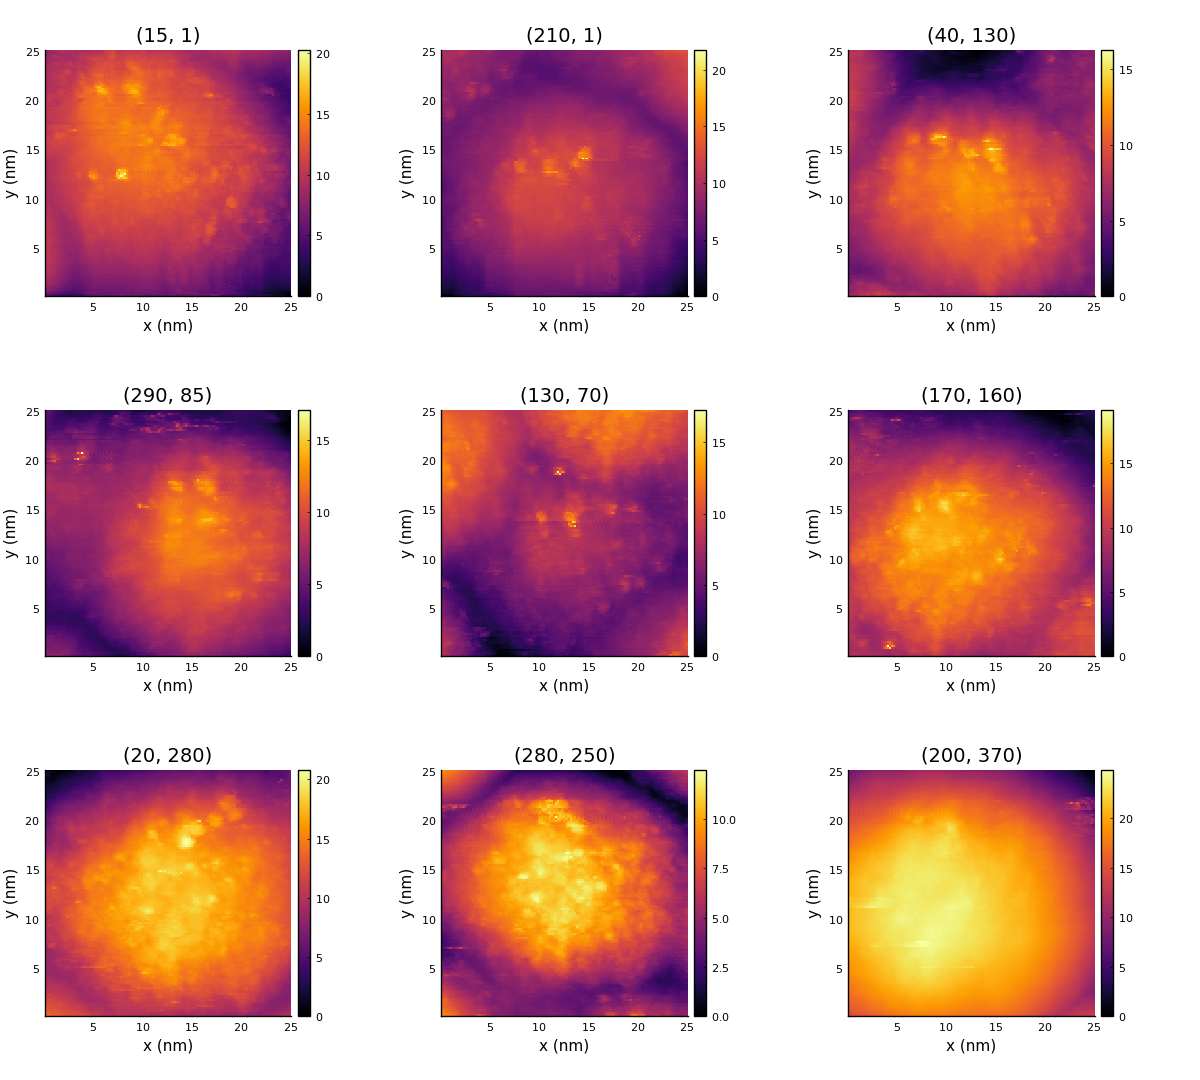

In [4]:
extract_size = (128,128)
lowerlefts = [
    (15,1), (210,1), (40,130), 
    (290,85), (130,70), (170, 160), 
    (20, 280), (280, 250), (200, 370)
]
plots = Vector{Plots.Plot}(undef, length(lowerlefts))
extracted_images = Vector{SPM.Image}(undef, length(lowerlefts))
for i = eachindex(lowerlefts)
    ll  = lowerlefts[i]
    extracted_images[i] = SPM.extract(image, ll, extract_size)
    extracted_images[i].data .= extracted_images[i].data .- minimum(extracted_images[i].data)
    plots[i] = SPM.showHeatmap(extracted_images[i]; title="$(ll)", legend=true)
end

plot(plots..., layout=(3,3), size=(1200, 1080))

In [5]:
thresholds = [0.01, 0.1, 0.5, 1.0]
tip_size = 64
villarrubiaResults = SPM.BTR.solveVillarrubiaBTR(
    extracted_images, tip_size, thresholds
)
typeof(villarrubiaResults)

[ Info: 1th thread : start solving for thresh = 0.01
[ Info: 2th thread : start solving for thresh = 0.1
[ Info: 4th thread : start solving for thresh = 1.0
[ Info: 3th thread : start solving for thresh = 0.5


Vector{VillarrubiaBTRResult} (alias for Array{Main.SPM.BTR.VillarrubiaBTRResult, 1})

[ Info: Showing tip shape


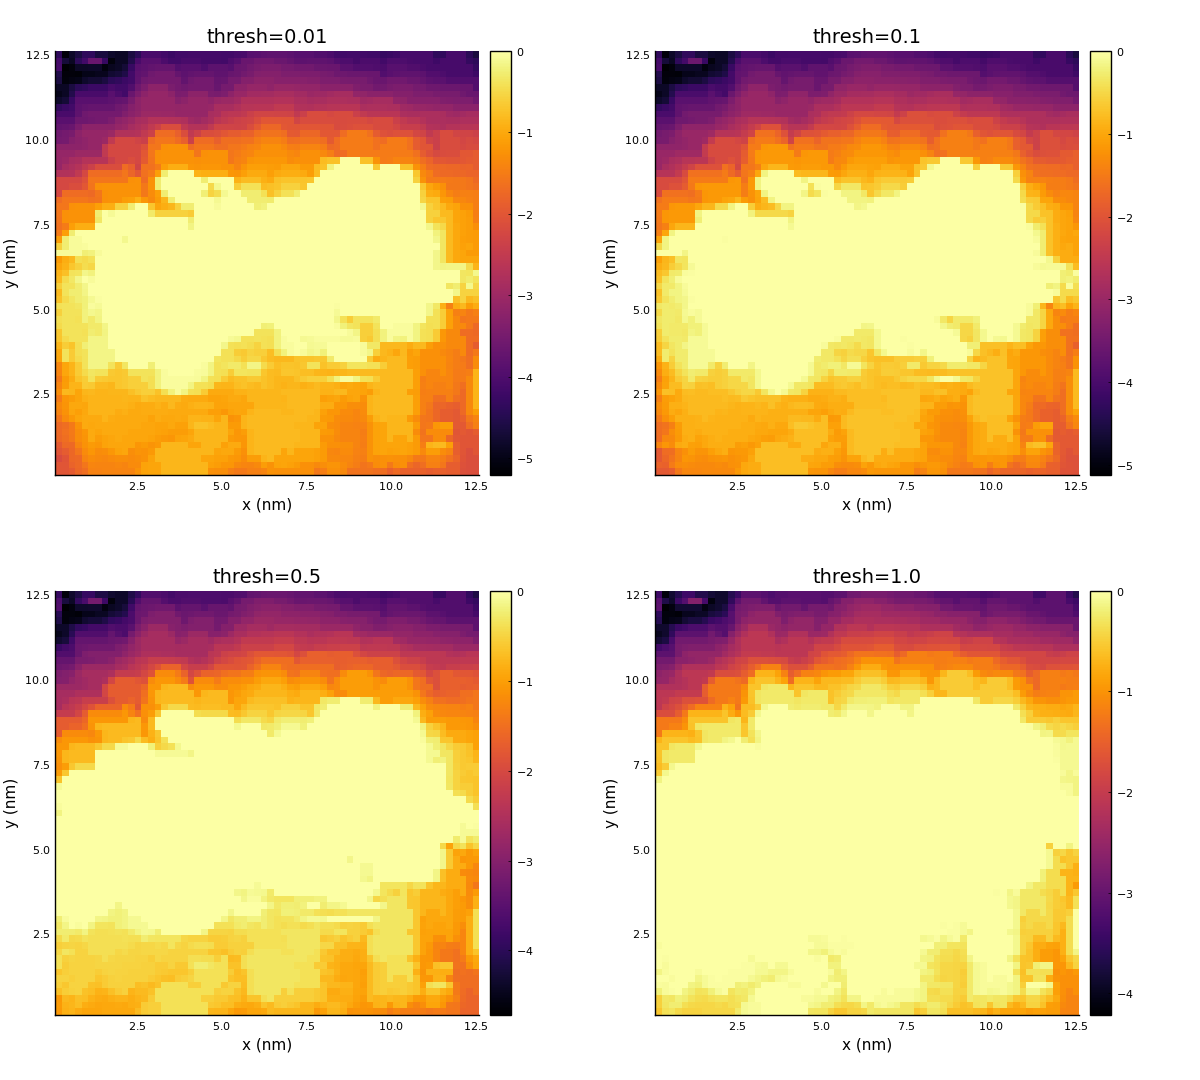

In [6]:
plots = Vector{Plots.Plot}(undef, length(villarrubiaResults))
for i = eachindex(villarrubiaResults)
    result_tip = villarrubiaResults[i].tip
    plots[i] = SPM.showHeatmap(result_tip; title="thresh=$(thresholds[i])", legend=true)
end
@info "Showing tip shape"
plot(plots..., layout=(2,2), size=(1200, 1080))

[ Info: Showing surface shape eroded with tip for thresh=0.01


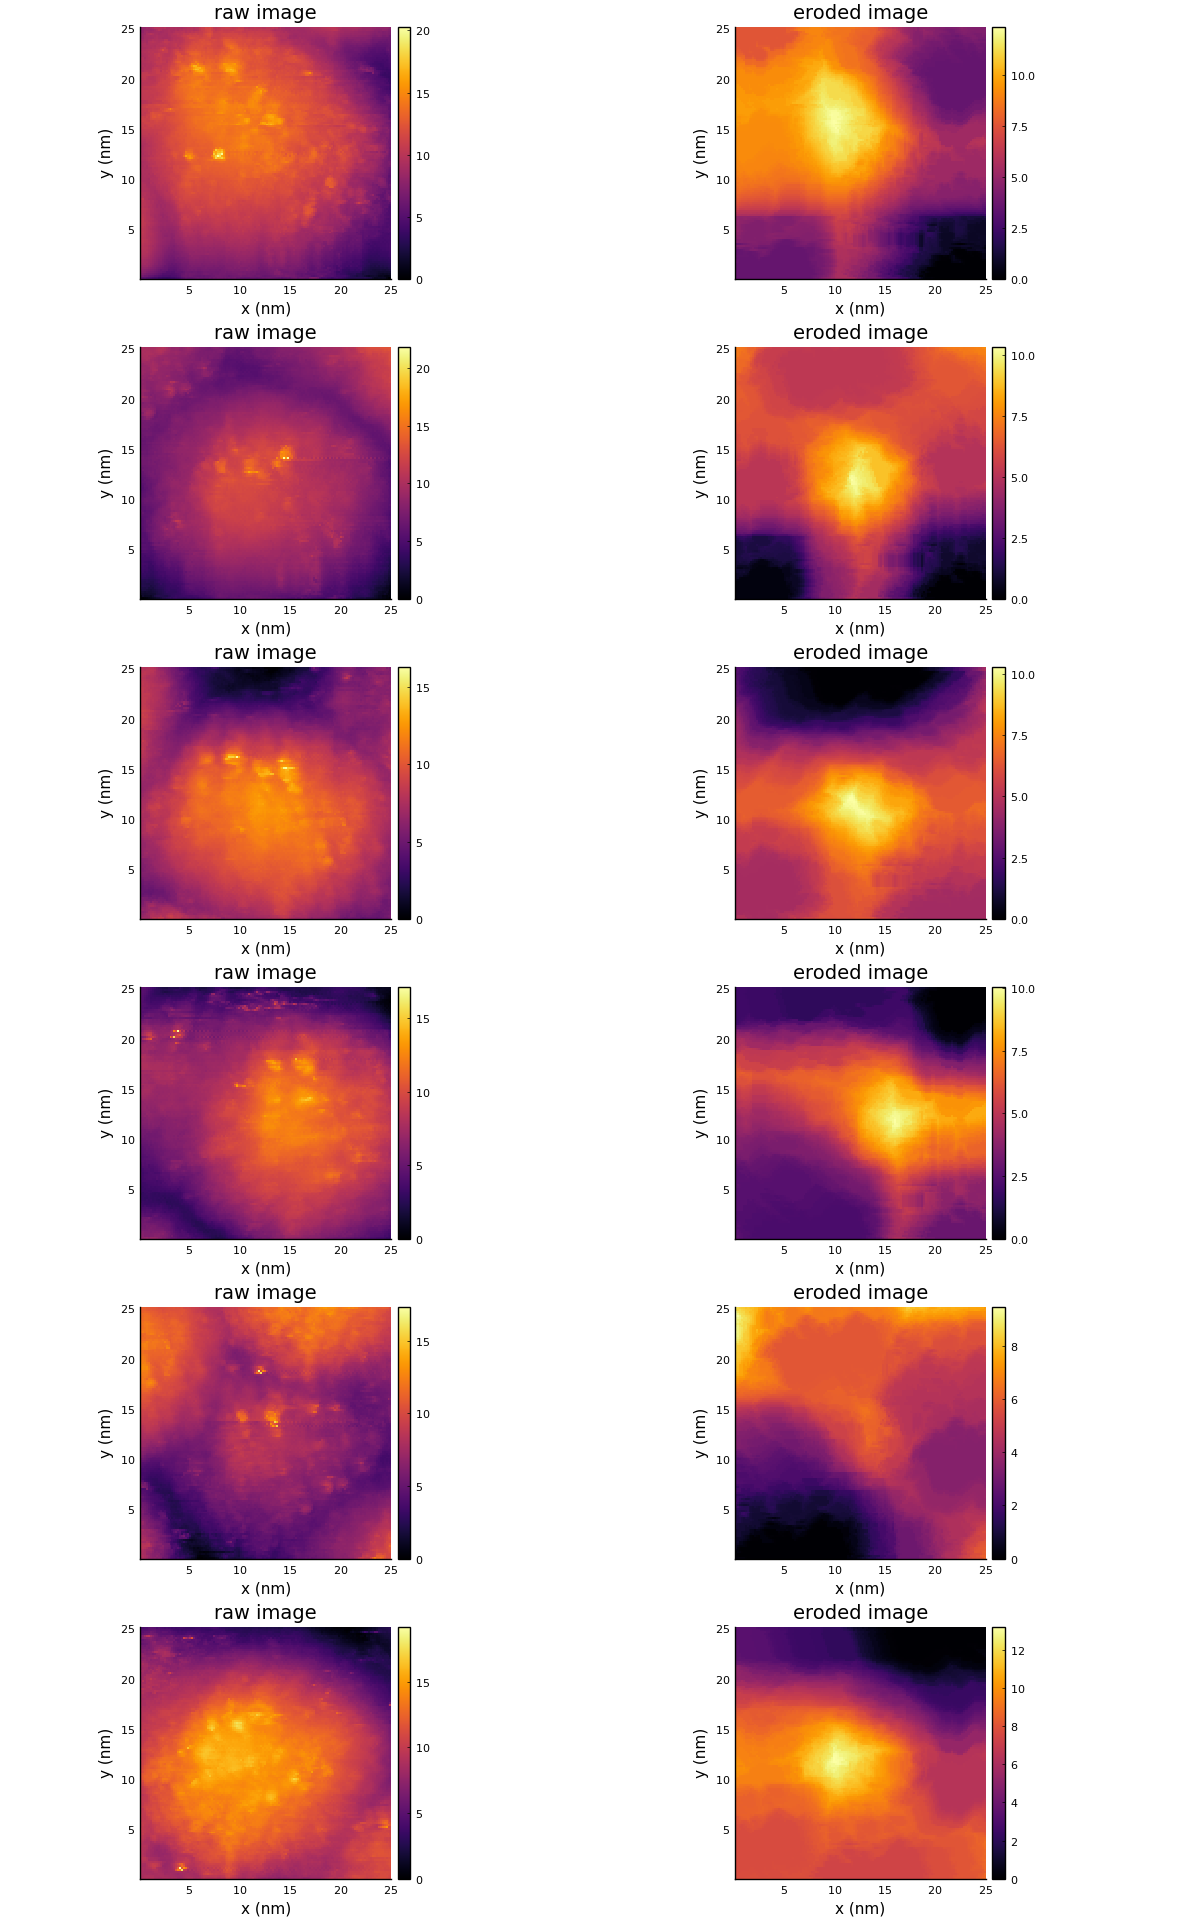

In [7]:
image_indice = [1, 2, 3, 4, 5, 6]
plots = Vector{Plots.Plot}(undef, 2*length(image_indice))

it = 1
tip = villarrubiaResults[it].tip

for i in image_indice
    raw_image = extracted_images[i]
    plots[2*(i-1)+1] = SPM.showHeatmap(raw_image; title="raw image")
    eroded_image = SPM.BTR.ierosion(raw_image, tip)
    plots[2i] = SPM.showHeatmap(eroded_image; title="eroded image")
end
@info "Showing surface shape eroded with tip for thresh=$(thresholds[it])"
plot(plots..., layout=(6,2), size=(1200, 1920))

In [8]:
tip_size = 64
max_epoch = 100
lambdas = [1.0e-8, 1e-6, 1e-4, 1e-2]
differentiableResults = SPM.BTR.solveDifferentiableBTR(
    extracted_images, tip_size, max_epoch, lambdas
)
println(typeof(differentiableResults))

[ Info: 3th thread : start solving for lambda = 1.0e-6
[ Info: 4th thread : start solving for lambda = 0.01
[ Info: 2th thread : start solving for lambda = 0.0001
[ Info: 1th thread : start solving for lambda = 1.0e-8
[ Info: 1th thread : optimizer setup completed
[ Info: 3th thread : optimizer setup completed
[ Info: 4th thread : optimizer setup completed
[ Info: 2th thread : optimizer setup completed
[ Info: 3th thread : 100th epoch completed in 913.465 sec
[ Info: 3th thread : 1th lambda completed
[ Info: 3th thread : 100th epoch completed in 917.291 sec
[ Info: 2th thread : 4th lambda completed
[ Info: 2th thread : 100th epoch completed in 917.535 sec
[ Info: 2th thread : 3th lambda completed
[ Info: 4th thread : 100th epoch completed in 918.222 sec
[ Info: 4th thread : 2th lambda completed


Vector{Main.SPM.BTR.DifferentiableBTRResult}


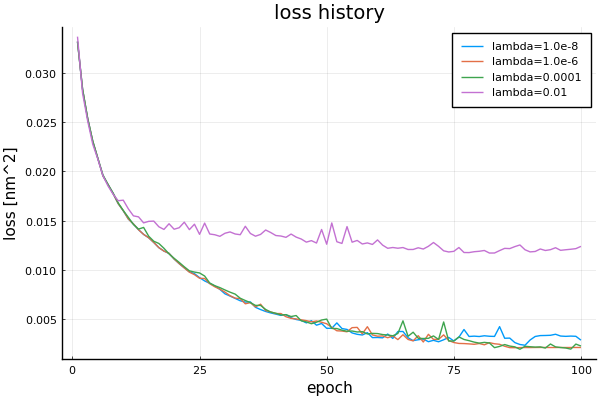

In [9]:
p = plot(title="loss history", xlabel="epoch", ylabel="loss [nm^2]")
for it = eachindex(differentiableResults)
    loss_history = differentiableResults[it].loss_history
    plot!(p, collect(1:max_epoch), loss_history ./ 100, label="lambda=$(lambdas[it])")
end
p

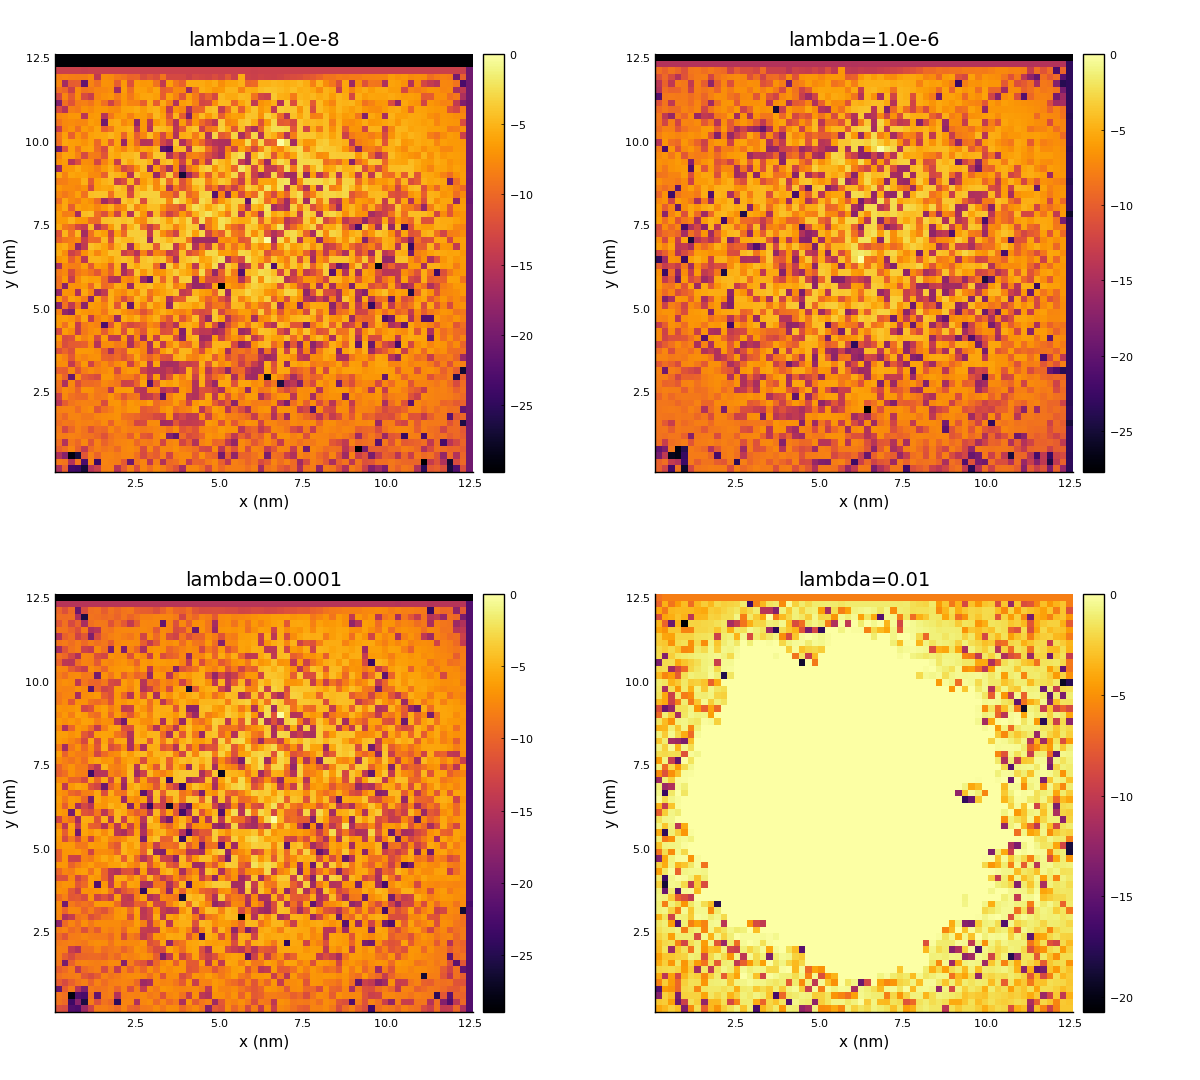

In [13]:
plots = Vector{Plots.Plot}(undef, length(differentiableResults))
for i = eachindex(differentiableResults)
    result_tip = differentiableResults[i].final_tip
    plots[i] = SPM.showHeatmap(result_tip; title="lambda=$(lambdas[i])", legend=true)
end
plot(plots..., layout=(2,2), size=(1200, 1080))

[ Info: Showing surface shape eroded with tip for lambda=0.01


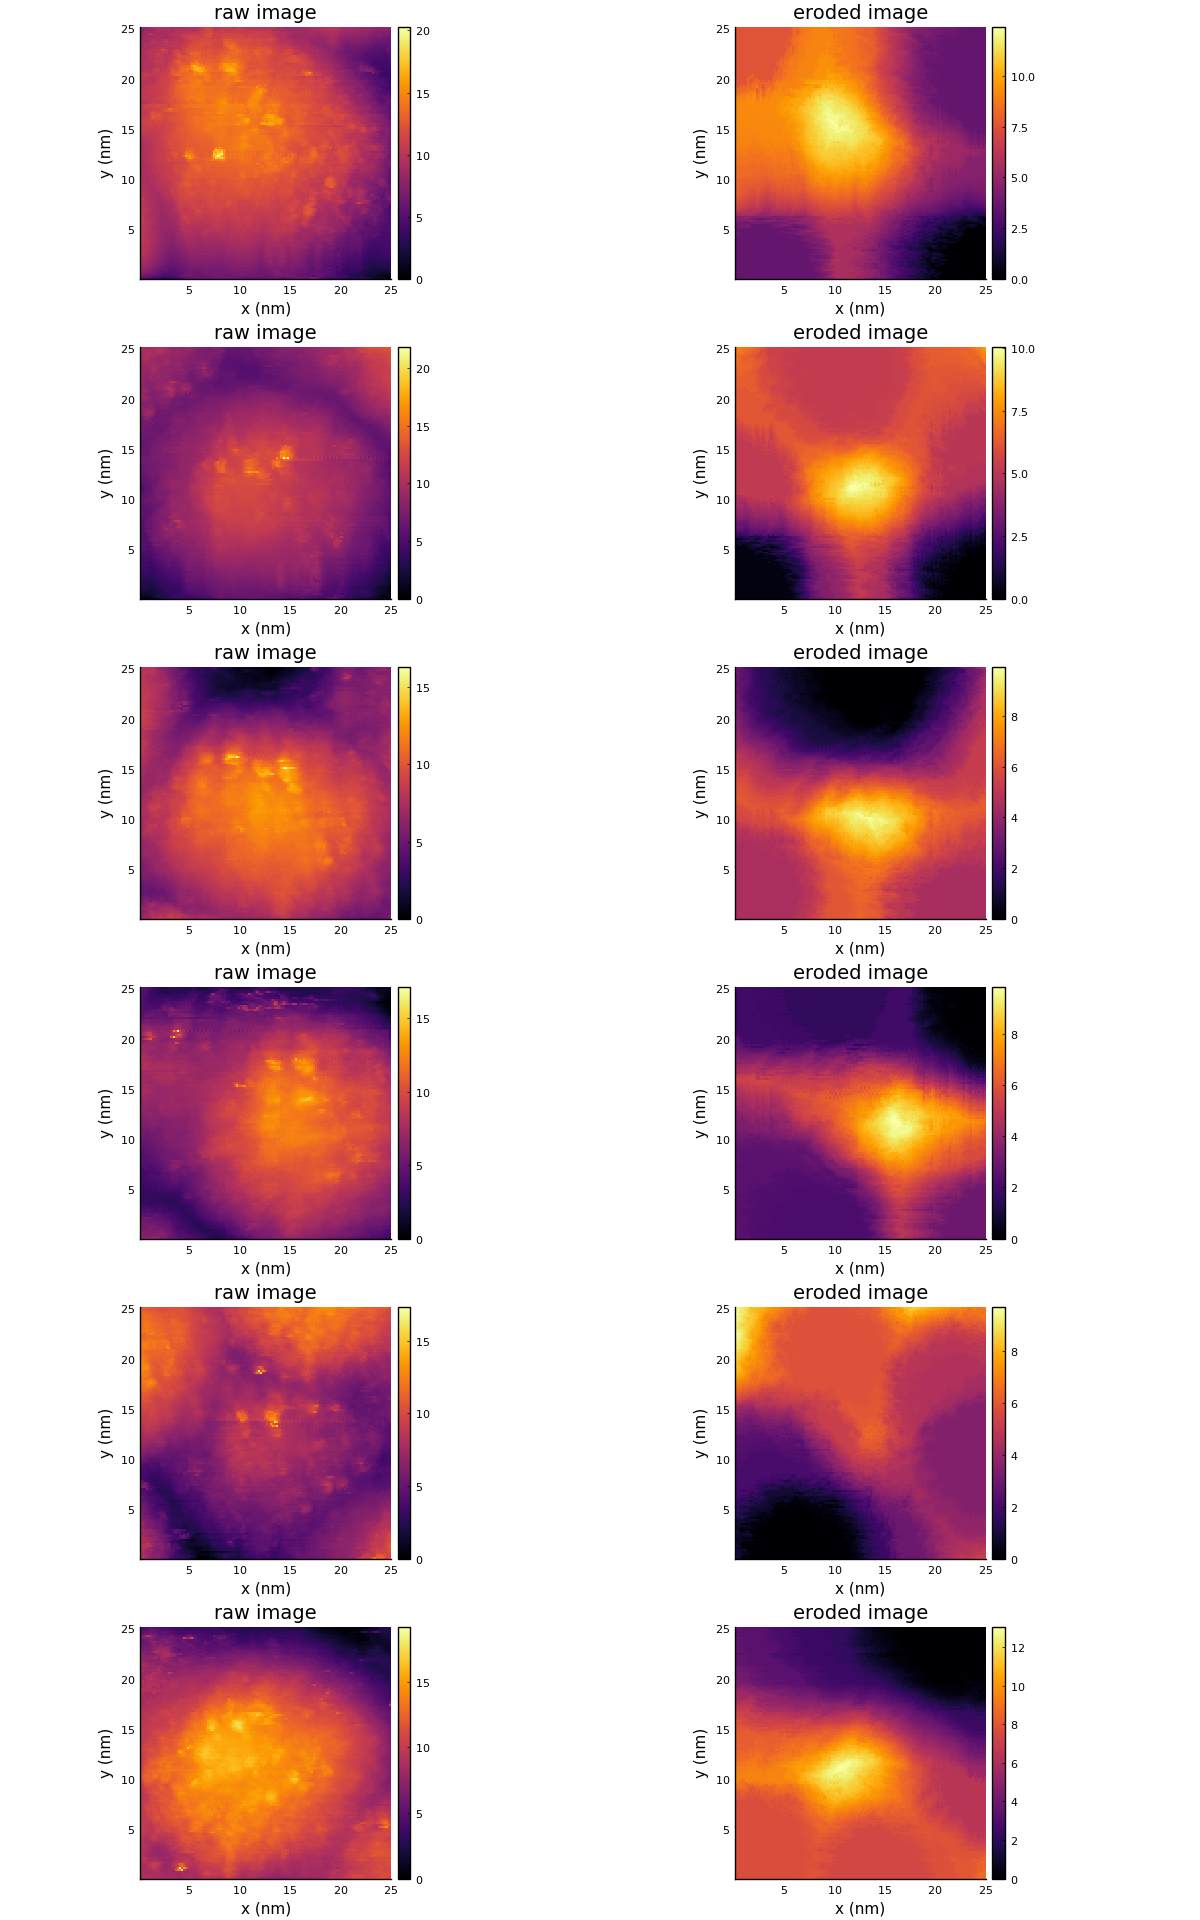

In [12]:
image_indice = [1, 2, 3, 4, 5, 6]
plots = Vector{Plots.Plot}(undef, 2*length(image_indice))

it = 4
tip = differentiableResults[it].final_tip

for i in image_indice
    raw_image = extracted_images[i]
    plots[2*(i-1)+1] = SPM.showHeatmap(raw_image; title="raw image")
    eroded_image = SPM.BTR.ierosion(raw_image, tip)
    plots[2i] = SPM.showHeatmap(eroded_image; title="eroded image")
end
@info "Showing surface shape eroded with tip for lambda=$(lambdas[it])"
p = plot(plots..., layout=(6,2), size=(1200, 1920))